# What makes a successful TV show?

This analysis and model attemts to determine the factors that influence high or low IMDb ratings for TV shows.  All generes are examined, and while most originate in the United States, there are a few from the UK and elsewhere included.   

Two separate models are developed.  In both, the top and bottom rated shows are classified as winners and losers, respectively, and an array of 12 classisfiers are applied using cross validation to identify the best performing model. 25% of the data was reserved as a test set, and cross-validation scores and test set scores are both shown in the tables below. Baseline score is 0.52.  

The first utilizes natural language processing (NLP) on the IMDb summary descriptions of each show.  Term Frequency - Inverse Document Frequency and Count Vectorization were used on n-grams of size 2-4 were used.  With both vectorization techniqes, Random Forrest and Naive Bayesian classifiers were most successful, with the highest score of 0.642 was achieved using TF-IDF vectorization and a Multinomial Naive Bayes classifier.   The n-grams with highest cumulative score are identified as the most significant factors in the model, giving a clue as to the words in a summary description that foretell a show's likelihood of being a winner or loser.  

A second model, using factors such as genre, lenght, schedule times, network and format was also built, and the same set of 12 classifiers was applied.  The ADA Boost classifier achieved the top score of 0.92 using these factors.  

_Data collection and cleanup was tedious, and involved multiple runs of webscraping IMDb pages on show ratings, then using the TVmaze API to return show detals.  Unless interested in these details, the reader is encouraged to skip to the section titled "Modeling Section" a bit more than halfway through this notebook._

**Results Summary:**

From the NLP models, it seems shows featuring adult characters in crime and drama series set in times before or after the present in New York will fare better than reality or animated series featuring children or teens and highlighting pop culture.  

The model on the factors other than the summary showed similar tendencies.  Realty formats were the strongest negative factor in predicting success, while the scripted format was the strongest positive predictor.  Game and Talk shows were negative, while crime, science fiction, comedy, drama and documentaries were positive predictors.   Shows aired by HBO and BBC predicted success, while the lower rated shows were found more predominantly on MTV, E!, Comedy Central and Lifetime.  

Though interesting associations have been found, it must be said that nothing in the techniques used here can be interpreted as causality. For example, it cannot be said that reality shows featuring teenagers will always flop.  This report is based on initial efforts to determine factors that may influence a show’s success, and have shown a path for future more detailed modeling.  Suggested future paths include textual analysis of critics’ reviews, analysis based on cast or producers, analysis of differences in rating based on audience demographics, and a more detailed look at the connection between genre and the type/style of show.  

In [2]:
# Import libraries needed for scraping and saving results.  
# Additional libraries needed for modeling, analysis and display will be imported when needed.

import requests
import pandas as pd
from bs4 import BeautifulSoup
import pickle

## Data Acquisition:  List of top rated TV Shows 

In [3]:
# Retrieve current top 250 TV shows webpage

url = "http://www.imdb.com/chart/toptv/"
r = requests.get(url)
html = r.text
html[0:200]

u'\n\n\n\n<!DOCTYPE html>\n<html\nxmlns:og="http://ogp.me/ns#"\nxmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=ed'

In [4]:
# Use Beautiful soup to extract the imdb numbers from the webpage
soup = BeautifulSoup(html, "lxml")

In [5]:
# Scrape the IMDb numbers for the 250 top rated shows

show_list = []
for tbody in soup.findAll('tbody', class_='lister-list'):
    for title in tbody.findAll('td', class_='titleColumn'):
        show_list.append(str(title.findAll('a')).split("/")[2])

show_list


['tt5491994',
 'tt0185906',
 'tt0795176',
 'tt0944947',
 'tt0903747',
 'tt0306414',
 'tt2861424',
 'tt2395695',
 'tt0081846',
 'tt0071075',
 'tt0141842',
 'tt1475582',
 'tt1533395',
 'tt0417299',
 'tt0098769',
 'tt1806234',
 'tt0303461',
 'tt0092337',
 'tt0052520',
 'tt3530232',
 'tt2356777',
 'tt1355642',
 'tt2802850',
 'tt0103359',
 'tt0296310',
 'tt0877057',
 'tt4508902',
 'tt0475784',
 'tt2092588',
 'tt0213338',
 'tt1856010',
 'tt0063929',
 'tt0112130',
 'tt2571774',
 'tt0081834',
 'tt0367279',
 'tt4742876',
 'tt4574334',
 'tt2085059',
 'tt0108778',
 'tt0098904',
 'tt3718778',
 'tt0081912',
 'tt0098936',
 'tt1518542',
 'tt0074006',
 'tt2707408',
 'tt0193676',
 'tt1865718',
 'tt0096548',
 'tt0072500',
 'tt0384766',
 'tt0118421',
 'tt0096697',
 'tt0090509',
 'tt0121955',
 'tt0386676',
 'tt4299972',
 'tt2560140',
 'tt0472954',
 'tt0412142',
 'tt0214341',
 'tt5555260',
 'tt2442560',
 'tt5712554',
 'tt0200276',
 'tt0353049',
 'tt1910272',
 'tt0086661',
 'tt0248654',
 'tt5189670',
 'tt01

In [11]:
# This code has been executed, and the results pickled and stored locally, so no need to run these requests
# to the API again. The api address with key to look up show with imdb number is
# http://api.tvmaze.com/lookup/shows?imdb=<show imdb identifier>

DO_NOT_RUN = True     # Do not run when notebook is loaded to avoid unnecessary calls to the API

if not DO_NOT_RUN:
    shows = pd.DataFrame()
    for show_id in show_list:
            try:
                print show_id
                # Get the tv show info from the api
                url = "http://api.tvmaze.com/lookup/shows?imdb=" + show_id
                r = requests.get(url)

                # convert the return data to a dictionary
                json_data = r.json()

                # load a temp datafram with the dictionary, then append to the composite dataframe
                temp_df = pd.DataFrame.from_dict(json_data, orient='index', dtype=None)
                ttemp_df = temp_df.T     # Was not able to load json in column orientation, so must transpose
                shows = shows.append(ttemp_df, ignore_index=True)
            except: 
                print show_id, " could not be retrieved from api"

    shows.head()    



In [12]:
# write the contents of an object to a file for later retrieval

DO_NOT_RUN = True   # Be sure to check the file name to write before enabling execution on this block

if not DO_NOT_RUN:
    pickle.dump( shows, open( "save_shows_df.p", "wb" ) )

## Get list of bottom rated TV Series

In [493]:
# This code block was changed multiple times to pull html with different sets of low rated shows
# ultimately about 1200 imdb ids were scraped, and about 1/3 of those could be pulled from the TV Maze API.

url ="http://www.imdb.com/search/title?count=600&languages=en&title_type=tv_series&user_rating=3.4,5.0&sort=user_rating,asc"
r = requests.get(url)
html = r.text
html[0:200]

u'\n\n\n\n<!DOCTYPE html>\n<html\nxmlns:og="http://ogp.me/ns#"\nxmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=ed'

In [494]:
# Use Beautiful soup to extract the imdb numbers from the webpage
soup = BeautifulSoup(html, "lxml")

loser_list = []
for div in soup.findAll('div', class_='lister-list'):
    for h3 in div.findAll('h3', class_='lister-item-header'):
        loser_list.append(str(h3.findAll('a')).split("/")[2])

loser_list


['tt0773264',
 'tt1798695',
 'tt1307083',
 'tt4845734',
 'tt0046641',
 'tt1519575',
 'tt0853078',
 'tt0118423',
 'tt0284767',
 'tt4052124',
 'tt0878801',
 'tt3703500',
 'tt1105170',
 'tt4363582',
 'tt3155428',
 'tt0362350',
 'tt0287196',
 'tt2766052',
 'tt0405545',
 'tt0262975',
 'tt0367278',
 'tt7134262',
 'tt1695352',
 'tt0421470',
 'tt2466890',
 'tt0343305',
 'tt1002739',
 'tt1615697',
 'tt0274262',
 'tt0465320',
 'tt1388381',
 'tt0358889',
 'tt1085789',
 'tt1011591',
 'tt0364804',
 'tt1489335',
 'tt3612584',
 'tt0363377',
 'tt0111930',
 'tt0401913',
 'tt0808086',
 'tt0309212',
 'tt5464192',
 'tt0080250',
 'tt4533338',
 'tt4741696',
 'tt1922810',
 'tt1793868',
 'tt4789316',
 'tt0185054',
 'tt1079622',
 'tt1786048',
 'tt0790508',
 'tt1716372',
 'tt0295098',
 'tt3409706',
 'tt0222574',
 'tt2171325',
 'tt0442643',
 'tt2142117',
 'tt0371433',
 'tt0138244',
 'tt1002010',
 'tt0495557',
 'tt1811817',
 'tt5529996',
 'tt1352053',
 'tt0439346',
 'tt0940147',
 'tt3075138',
 'tt1974439',
 'tt26

In [495]:
len(loser_list)

600

In [492]:
# first_loser_list = loser_list

In [41]:
# This code has been executed, and the results pickled and stored locally, so no need to run these requests
# to the API again

DO_NOT_RUN = True

if not DO_NOT_RUN:
    losers = pd.DataFrame()
    for loser_id in loser_list:
            try:
                print loser_id
                # Get the tv show info from the api
                url = "http://api.tvmaze.com/lookup/shows?imdb=" + loser_id
                r = requests.get(url)

                # convert the return data to a dictionary
                json_data = r.json()

                # load a temp datafram with the dictionary, then append to the composite dataframe
                temp_df = pd.DataFrame.from_dict(json_data, orient='index', dtype=None)
                ttemp_df = temp_df.T     # Was not able to load json in column orientation, so must transpose
                losers = losers.append(ttemp_df, ignore_index=True)
            except: 
                print loser_id, " could not be retrieved from api"

    losers.head()    



tt0465347
tt0465347  could not be retrieved from api
tt4427122
tt4427122  could not be retrieved from api
tt1015682
tt1015682  could not be retrieved from api
tt2505738
tt2505738  could not be retrieved from api
tt2402465
tt2402465  could not be retrieved from api
tt0278236
tt0278236  could not be retrieved from api
tt0268066
tt0268066  could not be retrieved from api
tt4813760
tt4813760  could not be retrieved from api
tt1526001
tt1526001  could not be retrieved from api
tt1243976
tt1243976  could not be retrieved from api
tt2058498
tt3897284
tt3897284  could not be retrieved from api
tt3665690
tt3665690  could not be retrieved from api
tt4132180
tt4132180  could not be retrieved from api
tt0824229
tt0824229  could not be retrieved from api
tt0314990
tt0314990  could not be retrieved from api
tt5423750
tt5423750  could not be retrieved from api
tt5423664
tt5423664  could not be retrieved from api
tt2175125
tt2175125  could not be retrieved from api
tt0404593
tt0404593  could not be re

tt0315030  could not be retrieved from api
tt2337185
tt2337185  could not be retrieved from api
tt0775356
tt0775356  could not be retrieved from api
tt0244356
tt0244356  could not be retrieved from api
tt2338400
tt2338400  could not be retrieved from api
tt0220047
tt0220047  could not be retrieved from api
tt0341789
tt0341789  could not be retrieved from api
tt0197151
tt0197151  could not be retrieved from api
tt0222529
tt0222529  could not be retrieved from api
tt6086050
tt6086050  could not be retrieved from api
tt3100634
tt1625263
tt1625263  could not be retrieved from api
tt2289244
tt2289244  could not be retrieved from api
tt1936732
tt0278229
tt0278229  could not be retrieved from api
tt0429438
tt0429438  could not be retrieved from api
tt1410490
tt1410490  could not be retrieved from api
tt5588910
tt5588910  could not be retrieved from api
tt3670858
tt3670858  could not be retrieved from api
tt1197582
tt0397182
tt0397182  could not be retrieved from api
tt1911975
tt1911975  could

tt1566044
tt0292845
tt2633208
tt1685317
tt0421158
tt1176154
tt3099832
tt0396337
tt0337790
tt0287847
tt0421343
tt0408364
tt0346300
tt0346300  could not be retrieved from api
tt2908564
tt2908564  could not be retrieved from api
tt0348894
tt6959064
tt6959064  could not be retrieved from api
tt1737565
tt1454730
tt0468999
tt1495163
tt2514488
tt2390003
tt0293725
tt0293725  could not be retrieved from api
tt0092362
tt0092362  could not be retrieved from api
tt0818895
tt0818895  could not be retrieved from api
tt1509653
tt1509653  could not be retrieved from api
tt1809909
tt1809909  could not be retrieved from api
tt1796975
tt1796975  could not be retrieved from api
tt6501522
tt6501522  could not be retrieved from api
tt0424611
tt0424611  could not be retrieved from api
tt0439932
tt0439932  could not be retrieved from api
tt4671004
tt0471048
tt0471048  could not be retrieved from api
tt1156526
tt1156526  could not be retrieved from api
tt0264226
tt0264226  could not be retrieved from api
tt117

In [1280]:
# Oops,  We've hit the API to hard.  A second attempt to pull low rated show information
# will be needed, with a time delay to stay within API limitations.


In [42]:
# This shape is misleading, as many of the rows simply contain a message that the API limit 
# had been exceeded

losers.shape

(229, 22)

In [47]:
# This is accurate, 235 shows from the top show list were obtained
shows.shape

(235, 20)

In [43]:
DO_NOT_RUN = True  # Be sure to check the file name to write before enabling execution on this block

if not DO_NOT_RUN:
    pickle.dump( losers, open( "save_losers_df.p", "wb" ) )

In [44]:
# read data back in from the saved file
losers2 = pickle.load( open( "save_losers_df.p", "rb" ) )

### This is the start of a second attempt to pull more TV shows with low ratings

This is needed.  After the first pull, and after cleanup, there were only 10 Shows left in the low rating category with complete information.   The cells below collect more data from the API for additional low rated shows.

In [447]:
losers.loc[0:9]['externals']

0    {u'thetvdb': 283995, u'tvrage': 40425, u'imdb'...
1    {u'thetvdb': 299234, u'tvrage': 50418, u'imdb'...
2    {u'thetvdb': 118021, u'tvrage': None, u'imdb':...
3    {u'thetvdb': 274705, u'tvrage': 31580, u'imdb'...
4    {u'thetvdb': 246161, u'tvrage': None, u'imdb':...
5    {u'thetvdb': 75638, u'tvrage': None, u'imdb': ...
6    {u'thetvdb': 260183, u'tvrage': 31024, u'imdb'...
7    {u'thetvdb': None, u'tvrage': None, u'imdb': u...
8    {u'thetvdb': 299688, u'tvrage': None, u'imdb':...
9    {u'thetvdb': 222481, u'tvrage': None, u'imdb':...
Name: externals, dtype: object

In [441]:
# In the first attempt, there were a number of shows where data was not returned becuase of two many api calls
# in quick succession. In order to re-submit those show ids, it is necessary to get a list of ids that were
# returned successfully, and then to remove them from the original list of ids before resubmitting.  
# losers_pulled is a list of ids that were successful on the previous attempt.

losers_pulled = []
no_imdb_at_idx = []
for i in range(len(losers)):
    try:
        losers_pulled.append(losers.loc[i,'externals']['imdb'])
    except:
        no_imdb_at_idx.append(i)
print no_imdb_at_idx
print
print losers_pulled
print len(losers_pulled)

[11, 35, 36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 228]

[u'tt2058498', u'tt4566242', u'tt1364951', u'tt2341819', u'tt1893088', u'tt0445890', u'tt2279571', u'tt1733734', u'tt1372153', u'tt1817054', u'tt2879822', u'tt0190177', u'tt5047510', u'tt5338860', u'tt1848281', u'tt6839504', u'tt2114184', u'tt1674023', u'tt1971860', u'tt3100634', u'tt1936732', u'tt1197582', u'tt1485389', u'tt2288050', u'tt1612920', u'tt0402701', u'

In [443]:
# There were that do not even include their own imdb number, and indicator that the pull was unsuccessful
# While a few of these might have been successful but have only limited data, most are unusuable.
# Thus all will be re-requested at a slower rate and any duplicates removed when the data is merged.

print len(no_imdb_at_idx)

136


In [438]:
# This generates a list of the original requests that were not successfully returned from the api.   
# First the will be requested again, using a time delay to avoid requesting more than the server
# will willingly return.  They will also be batched in groups of 100 ids

missing_losers = [x for x in loser_list if x not in losers_pulled]
missing_losers

['tt0465347',
 'tt4427122',
 'tt1015682',
 'tt2505738',
 'tt2402465',
 'tt0278236',
 'tt0268066',
 'tt4813760',
 'tt1526001',
 'tt1243976',
 'tt3897284',
 'tt3665690',
 'tt4132180',
 'tt0824229',
 'tt0314990',
 'tt5423750',
 'tt5423664',
 'tt2175125',
 'tt0404593',
 'tt4160422',
 'tt4552562',
 'tt5804854',
 'tt0886666',
 'tt5423824',
 'tt3500210',
 'tt0285357',
 'tt0280234',
 'tt1863530',
 'tt0280349',
 'tt2660922',
 'tt0292776',
 'tt0264230',
 'tt1102523',
 'tt3333790',
 'tt0320863',
 'tt0830848',
 'tt0939270',
 'tt1459294',
 'tt6026132',
 'tt1443593',
 'tt0354267',
 'tt0147749',
 'tt0161180',
 'tt4733812',
 'tt0367362',
 'tt5626868',
 'tt7268752',
 'tt0464767',
 'tt3550770',
 'tt6422012',
 'tt3154248',
 'tt5016274',
 'tt1715229',
 'tt0489426',
 'tt5798754',
 'tt2022182',
 'tt0303564',
 'tt3462252',
 'tt0329849',
 'tt5074180',
 'tt3900878',
 'tt3887402',
 'tt0149408',
 'tt1360544',
 'tt1718355',
 'tt2364950',
 'tt0285374',
 'tt5267590',
 'tt0314993',
 'tt0300870',
 'tt7036530',
 'tt56

In [496]:
# This processes the oringinal list of 600 ids, minus the ones that were successfully pulled, 
# into groups of 100 + 7 in last list
# break up the missing list into groups of 100
subset_loser_list = []
print len(missing_losers)
for i in range(len(missing_losers)/100):
    temp_list = []
    for j in range(100):
        temp_list.append(missing_losers[i*100 + j])
    subset_loser_list.append(temp_list)    

# get last 7
for j in range(500, len(missing_losers)):
    temp_list = []
    for j in range(500, len(missing_losers)):
        temp_list.append(missing_losers[j])

507


In [497]:
# After reprocessing the first list of ids a 2nd time,  there are still not enough samples of low rated shows
# A third list of 600 low rated shows was scraped from IMDB, and this list is broken into subsets of 100 here

subset_loser_list2 = []
print len(loser_list)
for i in range(len(loser_list)/100):
    temp_list = []
    for j in range(100):
        temp_list.append(loser_list[i*100 + j])
    subset_loser_list2.append(temp_list)    


600


In [500]:
subset_loser_list2[0]


['tt0773264',
 'tt1798695',
 'tt1307083',
 'tt4845734',
 'tt0046641',
 'tt1519575',
 'tt0853078',
 'tt0118423',
 'tt0284767',
 'tt4052124',
 'tt0878801',
 'tt3703500',
 'tt1105170',
 'tt4363582',
 'tt3155428',
 'tt0362350',
 'tt0287196',
 'tt2766052',
 'tt0405545',
 'tt0262975',
 'tt0367278',
 'tt7134262',
 'tt1695352',
 'tt0421470',
 'tt2466890',
 'tt0343305',
 'tt1002739',
 'tt1615697',
 'tt0274262',
 'tt0465320',
 'tt1388381',
 'tt0358889',
 'tt1085789',
 'tt1011591',
 'tt0364804',
 'tt1489335',
 'tt3612584',
 'tt0363377',
 'tt0111930',
 'tt0401913',
 'tt0808086',
 'tt0309212',
 'tt5464192',
 'tt0080250',
 'tt4533338',
 'tt4741696',
 'tt1922810',
 'tt1793868',
 'tt4789316',
 'tt0185054',
 'tt1079622',
 'tt1786048',
 'tt0790508',
 'tt1716372',
 'tt0295098',
 'tt3409706',
 'tt0222574',
 'tt2171325',
 'tt0442643',
 'tt2142117',
 'tt0371433',
 'tt0138244',
 'tt1002010',
 'tt0495557',
 'tt1811817',
 'tt5529996',
 'tt1352053',
 'tt0439346',
 'tt0940147',
 'tt3075138',
 'tt1974439',
 'tt26

In [592]:
# This block calls the API.   It is run repeatedly with each new sublist of 100 show ids,  sleeping 10
# seconds between each request.  There is a do not run flag that will prevent running this block if the 
# notebook is restarted.  The first time it was executed, a new dataframe called "more_losers" was initialized,
# and then commented out for subsequent executions so the data returned in eacn subsequent data request will
# be appended to the bottom of the dataframe.

# After collection is complete, set flag to prevent running this block unnecessarily if notebook is restarted

import time
DO_NOT_RUN = True

if not DO_NOT_RUN:
#     responses = []
#     more_losers = pd.DataFrame()
    for loser_id in subset_loser_list2[0]:   # change the index and re-run to accesses each set of 100 ids
        time.sleep(10)    
        try: 
            # Get the tv show info from the api
            url = "http://api.tvmaze.com/lookup/shows?imdb=" + loser_id
            r = requests.get(url)

            # convert the return data to a dictionary
            json_data = r.json()

            # load a temp datafram with the dictionary, then append to the composite dataframe
            temp_df = pd.DataFrame.from_dict(json_data, orient='index', dtype=None)
            ttemp_df = temp_df.T     # Was not able to load json in column orientation, so must transpose
            more_losers = more_losers.append(ttemp_df, ignore_index=True)
            stat = ''
        except: 
            stat = 'failed'

        print loser_id, stat, r.status_code
        res = [loser_id, stat, r.status_code]
        responses.append(res)
        
    losers.head()    



tt0773264  200
tt1798695  200
tt1307083  200
tt4845734  200
tt0046641 failed 404
tt1519575 failed 404
tt0853078 failed 404
tt0118423 failed 404
tt0284767  200
tt4052124 failed 404
tt0878801  200
tt3703500  200
tt1105170 failed 404
tt4363582 failed 404
tt3155428  200
tt0362350 failed 404
tt0287196  200
tt2766052  200
tt0405545 failed 404
tt0262975  200
tt0367278 failed 404
tt7134262 failed 404
tt1695352 failed 404
tt0421470 failed 404
tt2466890 failed 404
tt0343305 failed 404
tt1002739 failed 404
tt1615697 failed 404
tt0274262 failed 404
tt0465320 failed 404
tt1388381  200
tt0358889  200
tt1085789 failed 404
tt1011591  200
tt0364804 failed 404
tt1489335 failed 404
tt3612584  200
tt0363377 failed 404
tt0111930 failed 404
tt0401913 failed 404
tt0808086 failed 404
tt0309212 failed 404
tt5464192  200
tt0080250 failed 404
tt4533338 failed 404
tt4741696  200
tt1922810 failed 404
tt1793868 failed 404
tt4789316 failed 404
tt0185054 failed 404
tt1079622 failed 404
tt1786048 failed 404
tt0790508 

In [593]:
len(responses)

1000

In [594]:
for i in range(len(more_losers)):
    print more_losers.loc[i, 'externals']

{u'thetvdb': 279947, u'tvrage': 37045, u'imdb': u'tt3595870'}
{u'thetvdb': None, u'tvrage': 13173, u'imdb': u'tt0848174'}
{u'thetvdb': 72157, u'tvrage': None, u'imdb': u'tt0374366'}
{u'thetvdb': 218241, u'tvrage': None, u'imdb': u'tt1684855'}
{u'thetvdb': 327908, u'tvrage': None, u'imdb': u'tt6842890'}
{u'thetvdb': 279810, u'tvrage': None, u'imdb': u'tt3501210'}
{u'thetvdb': 283658, u'tvrage': None, u'imdb': u'tt0367323'}
{u'thetvdb': 271341, u'tvrage': 33650, u'imdb': u'tt2633208'}
{u'thetvdb': 260677, u'tvrage': None, u'imdb': u'tt2579722'}
{u'thetvdb': 77616, u'tvrage': None, u'imdb': u'tt0072546'}
{u'thetvdb': 74419, u'tvrage': None, u'imdb': u'tt0458269'}
{u'thetvdb': None, u'tvrage': None, u'imdb': u'tt0249275'}
{u'thetvdb': 282527, u'tvrage': 42189, u'imdb': u'tt2815184'}
{u'thetvdb': 246631, u'tvrage': None, u'imdb': u'tt1753229'}
{u'thetvdb': 82500, u'tvrage': None, u'imdb': u'tt1240534'}
{u'thetvdb': 206381, u'tvrage': 26873, u'imdb': u'tt1999642'}
{u'thetvdb': 284259, u'tvra

In [591]:
more_losers

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,externals,premiered,summary,_links,image,webChannel,runtime,type,id,network
0,Ended,{u'average': None},[],0,1449178946,Famous in 12,English,"{u'days': [u'Tuesday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/9024/famous-in-12,None,"{u'thetvdb': 279947, u'tvrage': 37045, u'imdb'...",2014-06-03,"<p><i><b>""Famous in 12""</b></i>, the new unscr...",{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Reality,9024,{u'country': {u'timezone': u'America/New_York'...
1,Ended,{u'average': None},"[Comedy, Family]",14,1497059695,The Sharon Osbourne Show,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/19004/the-sharon-o...,None,"{u'thetvdb': None, u'tvrage': 13173, u'imdb': ...",2006-08-29,<p>Daily talk show hosted by Sharon Osbourne.</p>,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Talk Show,19004,"{u'country': {u'timezone': u'Europe/London', u..."
2,Ended,{u'average': None},[Comedy],0,1503083428,Steve Harvey's Big Time Challenge,English,"{u'days': [u'Sunday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/29202/steve-harvey...,None,"{u'thetvdb': 72157, u'tvrage': None, u'imdb': ...",2003-09-11,"<p><b>Steve Harvey's Big Time Challenge</b>, a...",{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Talk Show,29202,{u'country': {u'timezone': u'America/New_York'...
3,Ended,{u'average': None},[],0,1475183910,The Spin Crowd,English,"{u'days': [u'Sunday'], u'time': u'22:30'}",http://www.tvmaze.com/shows/21619/the-spin-crowd,None,"{u'thetvdb': 218241, u'tvrage': None, u'imdb':...",2010-08-22,<p>Nobody knows how to make stars shine bright...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Reality,21619,{u'country': {u'timezone': u'America/New_York'...
4,Running,{u'average': 1},[],0,1495714601,Babushka,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/25450/babushka,http://www.itv.com/beontv/shows/babushka,"{u'thetvdb': 327908, u'tvrage': None, u'imdb':...",2017-05-01,<p><b>Babushka</b> is a brand new game show wh...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Game Show,25450,"{u'country': {u'timezone': u'Europe/London', u..."
5,Ended,{u'average': None},[],0,1483745416,Chrome Underground,English,"{u'days': [u'Tuesday'], u'time': u'22:00'}",http://www.tvmaze.com/shows/24213/chrome-under...,http://www.discovery.com/tv-shows/chrome-under...,"{u'thetvdb': 279810, u'tvrage': None, u'imdb':...",2014-05-23,<p>Two international classic car dealers searc...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Reality,24213,{u'country': {u'timezone': u'America/New_York'...
6,Ended,{u'average': None},[],0,1495602919,Fear Factor,English,"{u'days': [u'Sunday'], u'time': u''}",http://www.tvmaze.com/shows/26838/fear-factor,None,"{u'thetvdb': 283658, u'tvrage': None, u'imdb':...",2002-09-10,<p>This version has two teams of three contest...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Game Show,26838,"{u'country': {u'timezone': u'Europe/London', u..."
7,Ended,{u'average': None},[],0,1495254081,Owner's Manual,English,"{u'days': [u'Thursday'], u'time': u'22:00'}",http://www.tvmaze.com/shows/9261/owners-manual,None,"{u'thetvdb': 271341, u'tvrage': 33650, u'imdb'...",2013-08-15,<p><b>Owner's Manual</b> will test one of the ...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Reality,9261,{u'country': {u'timezone': u'America/New_York'...
8,Ended,{u'average': None},[],0,1487011574,The Shire,English,"{u'days': [u'Monday'], u'time': u'21:45'}",htt

In [595]:
# Create a backup occasionally, and pickle after we've pulled the data
more_losers_backup = more_losers.copy()


In [596]:
DO_NOT_RUN = True  # Be sure to check the file name to write before enabling execution on this block

if not DO_NOT_RUN:
    pickle.dump( more_losers, open( "save_more_losers_df.p", "wb" ) )

### Add a column to both shows (good) and losers (bad) to classify the rows as winners or losers 

In [ ]:
# All the data pulled from api and placed in dataframes was pickled and written to disk.
# Reading it all back in and adding a column to indicate if it was a winner or loser
# then will clean up and begin the analysis.
# $ ls *.p
# save_losers_df.p    save_more_losers_df.p     save_shows_df.p

In [3]:
# read data back in from the saved file
winners = pickle.load( open( "save_shows_df.p", "rb" ) )
losers1 = pickle.load( open( "save_losers_df.p", "rb" ) )
losers2 = pickle.load( open( "save_more_losers_df.p", "rb" ) )

In [4]:
print " Winners:", winners.shape
print " Losers1:", losers1.shape
print " Losers2:", losers2.shape

 Winners: (235, 20)
 Losers1: (229, 22)
 Losers2: (170, 20)


In [5]:
# Investigate why Losers1 has 22 columns, must have been pickled after a change.   
losers1.columns

Index([u'_links', u'code', u'externals', u'genres', u'id', u'image',
       u'language', u'message', u'name', u'network', u'officialSite',
       u'premiered', u'rating', u'runtime', u'schedule', u'status', u'summary',
       u'type', u'updated', u'url', u'webChannel', u'weight'],
      dtype='object')

In [6]:
losers2.columns

Index([u'status', u'rating', u'genres', u'weight', u'updated', u'name',
       u'language', u'schedule', u'url', u'officialSite', u'externals',
       u'premiered', u'summary', u'_links', u'image', u'webChannel',
       u'runtime', u'type', u'id', u'network'],
      dtype='object')

In [7]:
winners.columns

Index([u'status', u'rating', u'genres', u'weight', u'updated', u'name',
       u'language', u'schedule', u'url', u'officialSite', u'externals',
       u'premiered', u'summary', u'_links', u'image', u'webChannel',
       u'runtime', u'type', u'id', u'network'],
      dtype='object')

In [8]:
# Correct the issue by copying correct columns from losers1 into new_losers1
cols = losers2.columns
new_losers1 = losers1[cols]

In [9]:
new_losers1.shape

(229, 20)

In [10]:
# check that all three dataframes have same data in same order
winners.head(2)

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,externals,premiered,summary,_links,image,webChannel,runtime,type,id,network
0,Ended,{u'average': 9.4},[Nature],87,1490631396,Planet Earth II,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/22036/planet-earth-ii,http://www.bbc.co.uk/programmes/p02544td,"{u'thetvdb': 318408, u'tvrage': None, u'imdb':...",2016-11-06,<p>David Attenborough presents a documentary s...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Documentary,22036,"{u'country': {u'timezone': u'Europe/London', u..."
1,Ended,{u'average': 9.4},"[Drama, Action, War, History]",86,1492651730,Band of Brothers,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/465/band-of-brothers,http://www.hbo.com/band-of-brothers,"{u'thetvdb': 74205, u'tvrage': 2708, u'imdb': ...",2001-09-09,<p>Drawn from interviews with survivors of Eas...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,465,{u'country': {u'timezone': u'America/New_York'...


In [11]:
new_losers1.head(2)

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,externals,premiered,summary,_links,image,webChannel,runtime,type,id,network
0,Running,{u'average': None},[],63,1463447317,The Bill Cunningham Show,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/6068/the-bill-cunn...,http://www.thebillcunninghamshow.com/,"{u'thetvdb': 283995, u'tvrage': 40425, u'imdb'...",2011-09-19,"<p><i><b>""The Bill Cunningham Show""</b>,</i> T...",{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Talk Show,6068,{u'country': {u'timezone': u'America/New_York'...
1,To Be Determined,{u'average': None},"[Comedy, Music]",0,1477139892,Six Degrees of Everything,English,"{u'days': [u'Tuesday'], u'time': u'23:00'}",http://www.tvmaze.com/shows/2821/six-degrees-o...,http://www.trutv.com/shows/six-degrees-of-ever...,"{u'thetvdb': 299234, u'tvrage': 50418, u'imdb'...",2015-08-18,<p><b>Six Degrees of Everything</b> is a fast-...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Variety,2821,{u'country': {u'timezone': u'America/New_York'...


In [12]:
losers2.head(2)

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,externals,premiered,summary,_links,image,webChannel,runtime,type,id,network
0,Ended,{u'average': None},[],0,1449178946,Famous in 12,English,"{u'days': [u'Tuesday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/9024/famous-in-12,None,"{u'thetvdb': 279947, u'tvrage': 37045, u'imdb'...",2014-06-03,"<p><i><b>""Famous in 12""</b></i>, the new unscr...",{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Reality,9024,{u'country': {u'timezone': u'America/New_York'...
1,Ended,{u'average': None},"[Comedy, Family]",14,1497059695,The Sharon Osbourne Show,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/19004/the-sharon-o...,None,"{u'thetvdb': None, u'tvrage': 13173, u'imdb': ...",2006-08-29,<p>Daily talk show hosted by Sharon Osbourne.</p>,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Talk Show,19004,"{u'country': {u'timezone': u'Europe/London', u..."


In [13]:
# Add a column to classify the shows as winners or losers (not winners)
winners['winner'] = 1
new_losers1['winner'] = 0
losers2['winner'] = 0


/Users/erhepp/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Merge into one dataframe called shows

In [14]:
# now concatenate the loser data to the winner data, the result is the dataframe shows
shows = pd.DataFrame()
shows = winners.copy()
shows = shows.append(new_losers1, ignore_index=True)
shows = shows.append(losers2, ignore_index=True)
shows.shape

(634, 21)

In [15]:
shows.head()

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,...,premiered,summary,_links,image,webChannel,runtime,type,id,network,winner
0,Ended,{u'average': 9.4},[Nature],87,1490631396,Planet Earth II,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/22036/planet-earth-ii,http://www.bbc.co.uk/programmes/p02544td,...,2016-11-06,<p>David Attenborough presents a documentary s...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Documentary,22036,"{u'country': {u'timezone': u'Europe/London', u...",1
1,Ended,{u'average': 9.4},"[Drama, Action, War, History]",86,1492651730,Band of Brothers,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/465/band-of-brothers,http://www.hbo.com/band-of-brothers,...,2001-09-09,<p>Drawn from interviews with survivors of Eas...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,465,{u'country': {u'timezone': u'America/New_York'...,1
2,Ended,{u'average': 9.2},[Nature],82,1502854135,Planet Earth,English,"{u'days': [u'Sunday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/768/planet-earth,http://www.bbc.co.uk/programmes/b006mywy,...,2006-03-05,<p>David Attenborough celebrates the amazing v...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Documentary,768,"{u'country': {u'timezone': u'Europe/London', u...",1
3,Running,{u'average': 9.3},"[Drama, Adventure, Fantasy]",100,1502955537,Game of Thrones,English,"{u'days': [u'Sunday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/82/game-of-thrones,http://www.hbo.com/game-of-thrones,...,2011-04-17,<p>Based on the bestselling book series <i>A S...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,82,{u'country': {u'timezone': u'America/New_York'...,1
4,Ended,{u'average': 9.3},"[Drama, Crime, Thriller]",97,1502331382,Breaking Bad,English,"{u'days': [u'Sunday'], u'time': u'22:00'}",http://www.tvmaze.com/shows/169/breaking-bad,http://www.amc.com/shows/breaking-bad,...,2008-01-20,<p><b>Breaking Bad</b> follows protagonist Wal...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,169,{u'country': {u'timezone': u'America/New_York'...,1


In [16]:
# Check id column for any duplicates. There will be some from the losers for two reasons:
#    During first pull, the API limitions were not known, so some were returned with message,
#       "Too Many Requests"  rather tahn data, these need to be removed
#    Some did not contain their own imdb number in the data, so when the list of imdb #s to recheck was generated, 
#        these had to be included in the 2nd attempt as they could not be identified as being in the first pull.  

shows = shows[shows['name'] != 'Too Many Requests']
print shows.shape

print "Duplicate show IDs", shows.duplicated('id').sum()

# Display the duplicates to visually examine before dropping
# shows[shows.isin(shows[shows.duplicated()])].sort("ID")
shows[shows.duplicated('id')]

(498, 21)
Duplicate show IDs 6


,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,...,premiered,summary,_links,image,webChannel,runtime,type,id,network,winner
601,Ended,{u'average': None},[],0,1477683583,Tyler Perry's House of Payne,English,"{u'days': [u'Friday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/14013/tyler-perrys...,None,...,2007-06-06,<p><b>Tyler Perry's House of Payne</b> is a co...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Scripted,14013,{u'country': {u'timezone': u'America/New_York'...,0
602,Ended,{u'average': 3.3},[Comedy],4,1502774582,The Inbetweeners,English,"{u'days': [u'Monday'], u'time': u'22:30'}",http://www.tvmaze.com/shows/1138/the-inbetweeners,None,...,2012-08-20,<p><b>The Inbetweeners</b> takes a comedic loo...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Scripted,1138,{u'country': {u'timezone': u'America/New_York'...,0
603,Ended,{u'average': 6},[Family],0,1497646938,19 Kids and Counting,English,"{u'days': [u'Tuesday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/969/19-kids-and-co...,http://www.tlc.com/tv-shows/19-kids-and-counting/,...,2008-09-29,<p><b>19 Kids and Counting</b> follows Michell...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Reality,969,{u'country': {u'timezone': u'America/New_York'...,0
604,Ended,{u'average': 9},"[Comedy, Food, Family]",0,1463627692,Talia in the Kitchen,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/2369/talia-in-the-...,http://www.nick.com/talia-in-the-kitchen/,...,2015-07-06,<p>When 14-year-old Talia visits her grandmoth...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,30,Scripted,2369,{u'country': {u'timezone': u'America/New_York'...,0
605,Running,{u'average': 3.8},[],48,1497310190,The Factor,English,"{u'days': [u'Monday', u'Tuesday', u'Wednesday'...",http://www.tvmaze.com/shows/9066/the-factor,http://www.foxnews.com/shows/the-oreilly-facto...,...,1996-10-07,"<p><b>The Factor</b>, originally titled <i>The...",{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,News,9066,{u'country': {u'timezone': u'America/New_York'...,0
606,Ended,{u'average': None},"[Drama, Comedy, Music]",0,1462214107,Viva Laughlin,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/6924/viva-laughlin,None,...,2007-10-18,<p>A remake of the British series <i>Blackpool...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,6924,{u'country': {u'timezone': u'America/New_York'...,0


In [17]:
# validate that these are really dups by looking at both rows with the duplicate id
shows[shows['id'] == 6924]

,status,rating,genres,weight,updated,name,language,schedule,url,officialSite,...,premiered,summary,_links,image,webChannel,runtime,type,id,network,winner
462,Ended,{u'average': None},"[Drama, Comedy, Music]",0,1462214107,Viva Laughlin,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/6924/viva-laughlin,None,...,2007-10-18,<p>A remake of the British series <i>Blackpool...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,6924,{u'country': {u'timezone': u'America/New_York'...,0
606,Ended,{u'average': None},"[Drama, Comedy, Music]",0,1462214107,Viva Laughlin,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/6924/viva-laughlin,None,...,2007-10-18,<p>A remake of the British series <i>Blackpool...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60,Scripted,6924,{u'country': {u'timezone': u'America/New_York'...,0


In [18]:
# All 6 of these check out as true duplicates, so remove the 2nd instance of each
shows = shows.drop_duplicates(subset='id')

In [19]:
shows.shape

(492, 21)

In [20]:
# make a copy, so there's a backup without having to re-pull shows info from api or from pickle and recombine
df_shows = shows.copy()

In [21]:
# Subdivide the columns so we can fit sections of the dataframe in notebook windows to see what we have
first_cols = df_shows.columns[1:10]
second_cols = df_shows.columns[10:17]
third_cols = df_shows.columns[17:]

In [22]:
df_shows[first_cols].head()

,rating,genres,weight,updated,name,language,schedule,url,officialSite
0,{u'average': 9.4},[Nature],87,1490631396,Planet Earth II,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/22036/planet-earth-ii,http://www.bbc.co.uk/programmes/p02544td
1,{u'average': 9.4},"[Drama, Action, War, History]",86,1492651730,Band of Brothers,English,"{u'days': [u'Sunday'], u'time': u'20:00'}",http://www.tvmaze.com/shows/465/band-of-brothers,http://www.hbo.com/band-of-brothers
2,{u'average': 9.2},[Nature],82,1502854135,Planet Earth,English,"{u'days': [u'Sunday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/768/planet-earth,http://www.bbc.co.uk/programmes/b006mywy
3,{u'average': 9.3},"[Drama, Adventure, Fantasy]",100,1502955537,Game of Thrones,English,"{u'days': [u'Sunday'], u'time': u'21:00'}",http://www.tvmaze.com/shows/82/game-of-thrones,http://www.hbo.com/game-of-thrones
4,{u'average': 9.3},"[Drama, Crime, Thriller]",97,1502331382,Breaking Bad,English,"{u'days': [u'Sunday'], u'time': u'22:00'}",http://www.tvmaze.com/shows/169/breaking-bad,http://www.amc.com/shows/breaking-bad


In [23]:
df_shows[second_cols].head()

,externals,premiered,summary,_links,image,webChannel,runtime
0,"{u'thetvdb': 318408, u'tvrage': None, u'imdb':...",2016-11-06,<p>David Attenborough presents a documentary s...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60
1,"{u'thetvdb': 74205, u'tvrage': 2708, u'imdb': ...",2001-09-09,<p>Drawn from interviews with survivors of Eas...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60
2,"{u'thetvdb': 79257, u'tvrage': 8077, u'imdb': ...",2006-03-05,<p>David Attenborough celebrates the amazing v...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60
3,"{u'thetvdb': 121361, u'tvrage': 24493, u'imdb'...",2011-04-17,<p>Based on the bestselling book series <i>A S...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60
4,"{u'thetvdb': 81189, u'tvrage': 18164, u'imdb':...",2008-01-20,<p><b>Breaking Bad</b> follows protagonist Wal...,{u'previousepisode': {u'href': u'http://api.tv...,{u'medium': u'http://static.tvmaze.com/uploads...,None,60


In [24]:
df_shows[third_cols].head()

,type,id,network,winner
0,Documentary,22036,"{u'country': {u'timezone': u'Europe/London', u...",1
1,Scripted,465,{u'country': {u'timezone': u'America/New_York'...,1
2,Documentary,768,"{u'country': {u'timezone': u'Europe/London', u...",1
3,Scripted,82,{u'country': {u'timezone': u'America/New_York'...,1
4,Scripted,169,{u'country': {u'timezone': u'America/New_York'...,1


## Cleanup and Organization of the DataFrame

In [25]:
# Cleanup and Organization

# The genres column is generally a list of strings, but is missing some values, and has empty lists for others.
#   !. Change all NaN to []
#   2. Convert all to strings
#   3. Use Count Vectorizer to make new columns for each genre
#   4. Remove existing genres column

df_shows['genres'] = df_shows['genres'].fillna(0).map(lambda x: [] if x == 0 else x)
df_shows['genres'] = df_shows['genres'].map(lambda x: ','.join(x))

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(
    binary=True,
    tokenizer=(lambda x: x.split(','))
    )
cvfit = cv.fit_transform(df_shows['genres']).todense()
genre_cols = pd.DataFrame(cvfit, columns=cv.get_feature_names())
genre_cols.rename(columns={'' : 'unknown'}, inplace=True)
genre_cols.columns

Index([        u'unknown',          u'action',           u'adult',
             u'adventure',           u'anime',        u'children',
                u'comedy',           u'crime',           u'drama',
             u'espionage',          u'family',         u'fantasy',
                  u'food',         u'history',          u'horror',
                 u'legal',         u'medical',           u'music',
               u'mystery',          u'nature',         u'romance',
       u'science-fiction',          u'sports',    u'supernatural',
              u'thriller',          u'travel',             u'war',
               u'western'],
      dtype='object')

In [27]:
new_genre_columns = []
for item in genre_cols:
    new_genre_columns.append('gn_' + item)
genre_cols.columns = new_genre_columns
genre_cols.head()

,gn_unknown,gn_action,gn_adult,gn_adventure,gn_anime,gn_children,gn_comedy,gn_crime,gn_drama,gn_espionage,...,gn_mystery,gn_nature,gn_romance,gn_science-fiction,gn_sports,gn_supernatural,gn_thriller,gn_travel,gn_war,gn_western
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
# Add the new genre columns to the df_shows dataframe
df_shows = pd.concat([df_shows, genre_cols], axis=1, join_axes=[df_shows.index])
df_shows = df_shows.drop('genres', 1)

In [34]:
# Genre information is missing for 69 loser shows and 13 winner shows

df_shows[df_shows['gn_unknown'] ==1][['gn_unknown', 'winner']].groupby(['winner']).count()

,gn_unknown
winner,
0,69
1,13


In [35]:
df_shows.columns

Index([            u'status',             u'rating',             u'weight',
                  u'updated',               u'name',           u'language',
                 u'schedule',                u'url',       u'officialSite',
                u'externals',          u'premiered',            u'summary',
                   u'_links',              u'image',         u'webChannel',
                  u'runtime',               u'type',                 u'id',
                  u'network',             u'winner',         u'gn_unknown',
                u'gn_action',           u'gn_adult',       u'gn_adventure',
                 u'gn_anime',        u'gn_children',          u'gn_comedy',
                 u'gn_crime',           u'gn_drama',       u'gn_espionage',
                u'gn_family',         u'gn_fantasy',            u'gn_food',
               u'gn_history',          u'gn_horror',           u'gn_legal',
               u'gn_medical',           u'gn_music',         u'gn_mystery',
            

In [36]:
# Convert the rating to a number
# sometimes the rating column is NaN, and sometimes the value for 'average' in the dictionary is Nan
# so the NaNs must be handled twice, once for each case
# This code first fills the missing dictionarys with -1 (value chosen to signify no rating)
# It then sets the column to the average value in the rating dictionary, and if that is NaN converts to -1

df_shows['rating'] = df_shows['rating'].fillna(-1).map(lambda x: -1 if x == -1 else x['average']).fillna(-1)

In [37]:
# Rating information is missing for 192 loser shows and 6 winner shows
df_shows[df_shows['rating'] == -1][['rating', 'winner']].groupby(['winner']).count()

,rating
winner,
0,192
1,6


In [38]:
# Unpack 'schedule' into days treating NaN in a similar way, 
df_shows['sched_day'] = df_shows['schedule'].fillna(0).map(lambda x: [] if x == 0 else x)
df_shows['sched_day'] = df_shows['sched_day'].map(lambda x: x if x == [] else x['days'])
df_shows['sched_day'] = df_shows['sched_day'].map(lambda x: ','.join(x))

In [39]:
cv = CountVectorizer(
    binary=True,
    tokenizer=(lambda x: x.split(','))
    )
cvfit = cv.fit_transform(df_shows['sched_day']).todense()
day_cols = pd.DataFrame(cvfit, columns=cv.get_feature_names())
day_cols.rename(columns={'' : 'unknown'}, inplace=True)
day_cols.columns

Index([  u'unknown',    u'friday',    u'monday',  u'saturday',    u'sunday',
        u'thursday',   u'tuesday', u'wednesday'],
      dtype='object')

In [40]:
new_day_columns = []
for item in day_cols:
    new_day_columns.append('sched_' + item)
day_cols.columns = new_day_columns
day_cols.head()

,sched_unknown,sched_friday,sched_monday,sched_saturday,sched_sunday,sched_thursday,sched_tuesday,sched_wednesday
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [41]:
# Add the new genre columns to the df_shows dataframe
df_shows = pd.concat([df_shows, day_cols], axis=1, join_axes=[df_shows.index])


In [42]:
df_shows = df_shows.drop('sched_day', 1)

In [43]:
# Scheduled Day information is missing for 15 loser shows and 45 winner shows

df_shows[df_shows['sched_unknown'] ==1][['sched_unknown', 'winner']].groupby(['winner']).count()

,sched_unknown
winner,
0,15
1,45


In [44]:
# Unpack 'schedule' into times treating NaN in a similar way.
# Samples with a valid show time will be HH:MM and missing values will be :
df_shows['sched_time'] = df_shows['schedule'].fillna(':').map(lambda x: x if x == ':' else x['time'])
df_shows['sched_time'] = df_shows['sched_time'].map(lambda x: ':' if x == '' else x)

In [45]:
# Scheduled Time information is missing for 35 loser shows and 61 winner shows

print len(df_shows[df_shows['sched_time'] == ':'])
df_shows[df_shows['sched_time'] == ':'][['sched_time', 'winner']].groupby(['winner']).count()

96


,sched_time
winner,
0,35
1,61


In [46]:
# Sched time is in HH:MM format as a string. I will leave this as string, and count vectorize it
print type(df_shows.loc[0,'sched_time'])

cv = CountVectorizer(
    binary=True,
    tokenizer=(lambda x: x.split(','))
    )
cvfit = cv.fit_transform(df_shows['sched_time']).todense()
time_cols = pd.DataFrame(cvfit, columns=cv.get_feature_names())
time_cols.rename(columns={':' : 'unknown'}, inplace=True)
time_cols.columns

<type 'unicode'>


Index([  u'00:00',   u'00:30',   u'00:50',   u'00:55',   u'01:00',   u'01:05',
         u'01:30',   u'01:35',   u'02:00',   u'02:05',   u'08:00',   u'10:00',
         u'11:00',   u'12:00',   u'13:00',   u'13:30',   u'14:00',   u'14:30',
         u'15:00',   u'15:15',   u'16:00',   u'16:30',   u'17:00',   u'17:15',
         u'17:30',   u'18:00',   u'18:30',   u'19:00',   u'19:30',   u'19:45',
         u'20:00',   u'20:15',   u'20:30',   u'20:40',   u'20:45',   u'20:55',
         u'21:00',   u'21:10',   u'21:15',   u'21:30',   u'21:45',   u'22:00',
         u'22:10',   u'22:30',   u'22:35',   u'23:00',   u'23:02',   u'23:15',
         u'23:30', u'unknown'],
      dtype='object')

In [47]:
new_time_columns = []
for item in time_cols:
    new_time_columns.append('sched_time_' + item)
time_cols.columns = new_time_columns
time_cols.head()

,sched_time_00:00,sched_time_00:30,sched_time_00:50,sched_time_00:55,sched_time_01:00,sched_time_01:05,sched_time_01:30,sched_time_01:35,sched_time_02:00,sched_time_02:05,...,sched_time_21:45,sched_time_22:00,sched_time_22:10,sched_time_22:30,sched_time_22:35,sched_time_23:00,sched_time_23:02,sched_time_23:15,sched_time_23:30,sched_time_unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
# Add the new genre columns to the df_shows dataframe
df_shows = pd.concat([df_shows, time_cols], axis=1, join_axes=[df_shows.index])


In [49]:
df_shows = df_shows.drop('schedule', 1)

In [50]:
df_shows = df_shows.drop('sched_time', 1)

In [51]:
print df_shows.columns

Index([            u'status',             u'rating',             u'weight',
                  u'updated',               u'name',           u'language',
                      u'url',       u'officialSite',          u'externals',
                u'premiered',
       ...
         u'sched_time_21:45',   u'sched_time_22:00',   u'sched_time_22:10',
         u'sched_time_22:30',   u'sched_time_22:35',   u'sched_time_23:00',
         u'sched_time_23:02',   u'sched_time_23:15',   u'sched_time_23:30',
       u'sched_time_unknown'],
      dtype='object', length=105)


In [52]:
# Print out a network dictionary to learn how to unpack the structure
df_shows.loc[0,'network']

{u'country': {u'code': u'GB',
  u'name': u'United Kingdom',
  u'timezone': u'Europe/London'},
 u'id': 12,
 u'name': u'BBC One'}

In [53]:
# 25 shows have no network info,  might need to drop these, but dummied for now
df_shows['network'].isnull().sum()

25

In [54]:
# Unpack 'network' into country code, country name, timezone,  treating NaN in a similar way, 
df_shows['country_code'] = df_shows['network'].fillna('').map(lambda x: x if x == '' else x['country'])
df_shows['country_code'] = df_shows['country_code'].map(lambda x: x if x == '' else x['code'])

df_shows['country_name'] = df_shows['network'].fillna('').map(lambda x: x if x == '' else x['country'])
df_shows['country_name'] = df_shows['country_name'].map(lambda x: x if x == '' else x['name'])

df_shows['country_tz'] = df_shows['network'].fillna('').map(lambda x: x if x == '' else x['country'])
df_shows['country_tz'] = df_shows['country_tz'].map(lambda x: x if x == '' else x['timezone'])

df_shows['network_id'] = df_shows['network'].fillna('').map(lambda x: x if x == '' else x['id'])
df_shows['network_name'] = df_shows['network'].fillna('').map(lambda x: x if x == '' else x['name'])


In [55]:
df_shows = df_shows.drop(['network'], 1)

In [56]:
# Country and network information is missing for 4 loser shows and 21 winner shows

df_shows[df_shows['country_code'] == ''] [['country_code', 'winner']].groupby(['winner']).count()

,country_code
winner,
0,4
1,21


In [57]:
df_shows[['country_code', 'country_name', 'country_tz', 'network_id', 'network_name']].head()

,country_code,country_name,country_tz,network_id,network_name
0,GB,United Kingdom,Europe/London,12,BBC One
1,US,United States,America/New_York,8,HBO
2,GB,United Kingdom,Europe/London,12,BBC One
3,US,United States,America/New_York,8,HBO
4,US,United States,America/New_York,20,AMC


In [58]:
df_shows[['updated', 'premiered']].head()

,updated,premiered
0,1490631396,2016-11-06
1,1492651730,2001-09-09
2,1502854135,2006-03-05
3,1502955537,2011-04-17
4,1502331382,2008-01-20


In [59]:
# Updated date is complete, premiered date is missing 6 values

print df_shows['updated'].isnull().sum()
print df_shows['premiered'].isnull().sum()


0
6


In [60]:
# Must represent updated as a real date time object, currently is seconds from epoch (1970)
# Convert string to int, then int to datetime
import datetime
print type(df_shows.loc[0,'updated'])

df_shows['updated'] = df_shows['updated'].fillna(0).apply(lambda x: x if x == 0 else datetime.datetime.fromtimestamp(x))


<type 'int'>


In [61]:
# Turn premiered into real date time object, currently this is a string, need to convert to date
print type(df_shows.loc[0,'premiered'])
df_shows['premiered'] = df_shows['premiered'].fillna(0).apply(lambda x: x if x == 0 else datetime.datetime.strptime(x, '%Y-%m-%d'))

<type 'unicode'>


In [62]:
df_shows[['updated', 'premiered']].head()

,updated,premiered
0,2017-03-27 12:16:36,2016-11-06 00:00:00
1,2017-04-19 21:28:50,2001-09-09 00:00:00
2,2017-08-15 23:28:55,2006-03-05 00:00:00
3,2017-08-17 03:38:57,2011-04-17 00:00:00
4,2017-08-09 22:16:22,2008-01-20 00:00:00


In [63]:
# Updated date is complete, premiered date is missing 6 values, all from loser shows

df_shows[df_shows['premiered'] == 0] [['premiered', 'winner']].groupby(['winner']).count()

,premiered
winner,
0,6


In [64]:
# Drop columns not useful for analysis

# webChannel has no or insufficient useful information, can drop
print "webChannel null count:", df_shows['webChannel'].isnull().sum()

# url, officialSite, externals, _links, image, webChannel
df_shows = df_shows.drop(['url', 'officialSite', 'externals', '_links', 'image', 'webChannel', ], 1)

webChannel null count: 464


In [65]:
# Looks like runtime is already an integer number of minutes
# runtime is missing 9 values, 5 winners and 4 losers
print type(df_shows.loc[0,'runtime'])
print df_shows['runtime'].isnull().sum(), " null values"
# df_shows['runtime'].value_counts()



<type 'int'>
9  null values


In [908]:
df_shows[df_shows['runtime'].isnull()][['runtime', 'winner']]

,runtime,winner
17,None,1
65,None,1
137,None,1
144,None,1
198,None,1
544,None,0
556,None,0
577,None,0
609,None,0


In [910]:
# Contains html tags, otherwise a string, html tags will be removed in text processing steps during analysis
print df_shows.loc[0,'summary']
print df_shows['summary'].isnull().sum(), " null values"

<p>David Attenborough presents a documentary series exploring how animals meet the challenges of surviving in the most iconic habitats on earth.</p>
1  null values


In [911]:
df_shows[df_shows['summary'].isnull()]

,status,rating,weight,updated,name,language,premiered,summary,runtime,type,...,sched_time_23:00,sched_time_23:02,sched_time_23:15,sched_time_23:30,sched_time_unknown,country_code,country_name,country_tz,network_id,network_name
570,Ended,-1.0,75,2017-04-18 17:55:28,Chop Socky Chooks,English,2008-03-07 00:00:00,None,11,Animation,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,11,Cartoon Network


In [912]:
# This one with the missing summary, Chop Socky Chooks, is missing other information also, and will be dropped.
# Too bad,  looks like a truly dreadful one that would be good for the very bottom of the losers list.
df_shows = df_shows[df_shows['summary'].notnull()]
df_shows.shape

(491, 104)

In [913]:
# Use textacy to clean the html tags, punctuation, etc. from the summary text
from textacy.preprocess import preprocess_text

df_shows['summary'] = df_shows['summary'].map(lambda x: preprocess_text(x, fix_unicode=True, lowercase=True, \
                              transliterate=False, no_contractions = True,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True))

In [914]:
print df_shows.loc[1,'summary']
print
print df_shows.loc[2,'summary']

<p>drawn from interviews with survivors of easy company as well as their journals and letters <b>band of brothers<b> chronicles the experiences of these men from paratrooper training in georgia through the end of the war as an elite rifle company parachuting into normandy early on dday morning participants in the battle of the bulge and witness to the horrors of war the men of easy knew extraordinary bravery and extraordinary fear and became the stuff of legend based on stephen e ambroses acclaimed book of the same name<p>

<p>david attenborough celebrates the amazing variety of the natural world in this epic documentary series filmed over four years across 64 different countries<p>


In [915]:
# Looks like all the summaries have html paragraph <p> and break <b> tags, and textacy hasn't removed them. 
# These lambda function knock them out

import string
df_shows['summary'] = df_shows['summary'].map(lambda x: x.replace('<p>',''))
df_shows['summary'] = df_shows['summary'].map(lambda x: x.replace('<b>',''))

In [916]:
# This looks better for analysis
print df_shows.loc[1,'summary']

drawn from interviews with survivors of easy company as well as their journals and letters band of brothers chronicles the experiences of these men from paratrooper training in georgia through the end of the war as an elite rifle company parachuting into normandy early on dday morning participants in the battle of the bulge and witness to the horrors of war the men of easy knew extraordinary bravery and extraordinary fear and became the stuff of legend based on stephen e ambroses acclaimed book of the same name


In [761]:
df_shows[df_shows.isnull().any(axis=1)]

,status,rating,weight,updated,name,language,premiered,summary,runtime,type,...,sched_time_23:00,sched_time_23:02,sched_time_23:15,sched_time_23:30,sched_time_unknown,country_code,country_name,country_tz,network_id,network_name
17,Ended,9.0,0,1455913373,The Decalogue,Polish,1989-12-10 00:00:00,"<p>Ten television drama films, each one based ...",None,Variety,...,0.0,0.0,0.0,0.0,1.0,PL,Poland,Europe/Warsaw,336,TVP1
65,Ended,9.0,85,1501781828,Sherlock Holmes,English,1984-04-24 00:00:00,<p><b>Sherlock Holmes</b> is one of the world'...,None,Scripted,...,0.0,0.0,0.0,0.0,0.0,GB,United Kingdom,Europe/London,35,ITV
137,Running,8.7,98,1489944935,Taboo,English,2017-01-07 00:00:00,<p>1814: James Keziah Delaney returns to Londo...,None,Scripted,...,0.0,0.0,0.0,0.0,0.0,GB,United Kingdom,Europe/London,12,BBC One
144,Ended,8.6,42,1494693177,The New Batman Adventures,English,1997-09-13 00:00:00,<p>The New Batman Adventures comes from the cr...,None,Animation,...,0.0,0.0,0.0,0.0,1.0,US,United States,America/New_York,71,The WB
198,Ended,9.0,0,1491564027,The Larry Sanders Show,English,1992-08-15 00:00:00,<p>Comic Garry Shandling draws upon his own ta...,None,Scripted,...,0.0,0.0,0.0,0.0,1.0,US,United States,America/New_York,8,HBO
492,Running,-1.0,76,1502312151,Big Brother After Dark,English,2007-07-05 00:00:00,"<p><b>Big Brother After Dark</b> is the live, ...",180,Reality,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,88,Pop
493,Ended,1.0,0,1474827145,American Paranormal,English,2010-01-24 00:00:00,"<p>Whether it is the existence of aliens, the ...",60,Reality,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,42,National Geographic Channel
494,Ended,-1.0,11,1469108505,Homeboys in Outer Space,English,1996-08-27 00:00:00,"<p>The plot centers around two astronauts, Tyb...",30,Scripted,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,70,UPN
495,Ended,-1.0,0,1485097253,Gainesville: Friends Are Family,English,2015-08-20 00:00:00,"<p><i><b>""Gainesville: Friends Are Family""</b>...",30,Documentary,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,173,CMT
496,Ended,-1.0,0,1449234102,The Show with Vinny,English,2013-05-01 00:00:00,"<p>Vinny Guadagnino invites musicians, TV star...",30,Talk Show,...,NaN,NaN,NaN,NaN,NaN,US,United States,America/New_York,22,MTV


In [917]:
# What do we have that is mostly complete
print df_shows[~df_shows.isnull().any(axis=1)]['winner'].value_counts()
df_shows_notnull = df_shows[~df_shows.isnull().any(axis=1)]

1    209
0    117
Name: winner, dtype: int64


In [921]:
# In the processing above, NaNs were replaced by other values for some columns.  This block creates a new
# dataframe where all rows with these coded values representing missing data have been removed.

df_shows_complete = df_shows_notnull[(df_shows_notnull['rating'] != -1) & \
                                     (df_shows_notnull['gn_unknown'] != 1) & \
                                     (df_shows_notnull['sched_unknown'] != 1) & \
                                     (df_shows_notnull['sched_time_unknown'] != 1) & \
                                     (df_shows_notnull['country_code'] != '') & \
                                     (df_shows_notnull['country_name'] != '') & \
                                     (df_shows_notnull['country_tz'] != '') & \
                                     (df_shows_notnull['network_id'] != '') & \
                                     (df_shows_notnull['network_name'] != '') & \
                                     (df_shows_notnull['premiered'] != 0)]

In [766]:
df_shows_complete.shape

(157, 103)

In [767]:
# Cool, at least not missing any summaries for samples that are otherwise complete
df_shows_complete['summary'].isnull().sum()

0

In [925]:
df_shows[['summary', 'winner']].groupby(['winner']).count()

,summary
winner,
0,256
1,235


## Modeling Section

  -- Note:  Cells in this section must be run sequentially to obtain correct results as some variables are reused in the various modeling sections

### Vectorize summary text in different ways

In [1282]:
# I'll first try a model with just the summary text, that is available for 491 shows, 256 loosers and 235 winners


# Use NLP techniques to create lots of factors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from collections import Counter

# Use different Vectorizers to find ngrams for us
tfidf = TfidfVectorizer(ngram_range=(2,4), max_features=2000, stop_words='english')
cvec = CountVectorizer(ngram_range=(2,4), max_features=2000, stop_words='english')
hvec = HashingVectorizer(ngram_range=(2,4), n_features=2000, stop_words='english')

X_tfidf = tfidf.fit_transform(df_shows['summary']).todense()
X_cvec = cvec.fit_transform(df_shows['summary']).todense()
X_hvec = hvec.fit_transform(df_shows['summary']).todense()

y = df_shows['winner'].values

print '\ntfidf shape:', X_tfidf.shape
print '\ncvec shape:', X_cvec.shape
print '\nhvec shape:', X_hvec.shape
print len(y)



tfidf shape: (491, 2000)

cvec shape: (491, 2000)

hvec shape: (491, 2000)
491


## Model on summary text using Count Vectorizer

- results were best when Count Vectorizer scores were modeled with Gaussian Naive Bayes


Features:     2000  
Train Set Accuracy:   0.905  
CrossVal Accuracy:     0.644 +/- 0.028   
Test Set Accuracy:   0.626   

**n-grams with higest cumulative sum of tf-idf scores for winners: **   'drama series', 'david attenborough', 'tells story', 'young boy', 'anthology series', 'documentary series', 'years later', 'main character', 'trials tribulations', 'crime drama', 'serial killer', 'tv history', 'super hero', 'story starts goku', 'starts goku', 'story starts', 'american television', 'fictional town', 'television drama', 'american crime'
  
**n-grams with higest cumulative sum of tf-idf scores for losers: ** 'real housewives', 'television series', 'reality series', 'follows lives', 'series produced', 'pop culture', 'reality television', 'reality television series', 'animated series', 'come true', 'aired abc', 'reality tv', 'series debuted', 'real housewives orange county', 'real housewives orange', 'housewives orange', 'housewives orange county', 'talk hosted', 'studio audience', 'cash prize'

  

In [1283]:
# Baseline for training set
winner_avg = y.mean()
baseline = max(winner_avg, 1-winner_avg)
print baseline

0.521384928717


In [1284]:
# Test Train Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cvec, y, test_size=0.25)

In [1285]:
print X_train.shape,  len(y_train)
print X_test.shape,  len(y_test)

(368, 2000) 368
(123, 2000) 123


In [1286]:
#  Standardize - 

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)



In [1287]:
# Run lots of classifiers on this and see which perform the best
# Import all the modeling libraries

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
                                    KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt


Baseline:   0.521 

Model:  Features    Train Set Accuracy    CrossVal Accuracy     Test Set Accuracy   
LR        2000         0.938               0.660 +/- 0.037         0.626 
LDA       2000         0.938               0.544 +/- 0.054         0.593 
QDA       2000         0.549               0.399 +/- 0.034         0.390 
KNN       2000         0.758               0.500 +/- 0.010         0.528 
CART      2000         0.943               0.576 +/- 0.028         0.585 
RFST      2000         0.940               0.636 +/- 0.046         0.626 
GB        2000         0.826               0.546 +/- 0.020         0.585 
ADA       2000         0.769               0.552 +/- 0.042         0.545 
SVM       2000         0.519               0.519 +/- 0.018         0.528 
GNB       2000         0.913               0.688 +/- 0.038         0.561 
    MNB  :   failed on this input dataset 
BNB       2000         0.902               0.625 +/- 0.023         0.602 


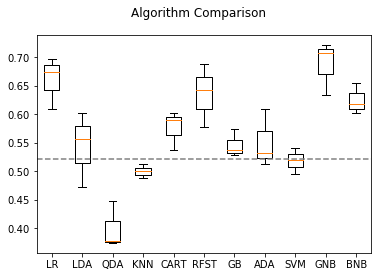

In [1288]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFST', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVM', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

print "\n{}:   {:0.3} ".format('Baseline', baseline, cv_results.std())
print "\n{:5.5}:  {:10.8}  {:20.18}  {:20.17}  {:20.17}".format\
        ("Model", "Features", "Train Set Accuracy", "CrossVal Accuracy", "Test Set Accuracy")

for name, model in models:
    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, Xs_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        this_model = model
        this_model.fit(X_train,y_train)
        print "{:5.5}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                (name, X_train.shape[1], metrics.accuracy_score(y_train, this_model.predict(Xs_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(y_test, this_model.predict(Xs_test)))
    except:
        print "    {:5.5}:   {} ".format(name, 'failed on this input dataset')

        
                
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline, color='grey', linestyle='--')
plt.show()

In [1289]:
# Which words are most common in the winner summaries ?
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# We can use the TfidfVectorizer to find ngrams for us
vect = CountVectorizer(ngram_range=(2,4), stop_words='english')

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(df_shows[df_shows['winner'] == 1]['summary'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'new york', 11),
 (u'drama series', 8),
 (u'york city', 6),
 (u'high school', 6),
 (u'men women', 5),
 (u'tv series', 5),
 (u'series based', 5),
 (u'video game', 5),
 (u'bugs bunny', 5),
 (u'new york city', 5),
 (u'tells story', 4),
 (u'young boy', 4),
 (u'comedy series', 4),
 (u'main character', 4),
 (u'united states', 4),
 (u'life new', 4),
 (u'series follows', 4),
 (u'anthology series', 3),
 (u'mr bean', 3),
 (u'prisoner cell', 3)]

In [1290]:
# Which words are most common in the loser summaries ?
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# We can use the TfidfVectorizer to find ngrams for us
vect = CountVectorizer(ngram_range=(2,4), stop_words='english')

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(df_shows[df_shows['winner'] == 0]['summary'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'real housewives', 12),
 (u'television series', 12),
 (u'los angeles', 11),
 (u'pop culture', 10),
 (u'series follows', 9),
 (u'new york', 9),
 (u'animated series', 7),
 (u'cartoon network', 7),
 (u'big brother', 6),
 (u'dance moms', 6),
 (u'reality series', 6),
 (u'best friend', 6),
 (u'high school', 5),
 (u'late night', 5),
 (u'best friends', 5),
 (u'nick jr', 5),
 (u'reality television series', 5),
 (u'plastic surgery', 5),
 (u'access hollywood', 5),
 (u'comedy series', 5)]

In [1291]:
# Sum matrix columns to see what has the most overall importance ?

print "Highest sum Count Vectoror score for n_grams in winner shows"

cvec_results = pd.DataFrame(Xs_train, columns=cvec.get_feature_names())
cvec_results['winners'] = y_train

winner_results = pd.DataFrame(cvec_results[cvec_results['winners'] ==1].sum(), columns=['cvec_sum'])


high = winner_results.drop(['winners']).sort_values('cvec_sum', axis=0, ascending=False).head(20).index
print  [str(r) for r in high]

winner_results.drop(['winners']).sort_values('cvec_sum', axis=0, ascending=False).head(20)


Highest sum Count Vectoror score for n_grams in winner shows
['drama series', 'david attenborough', 'main character', 'tells story', 'years later', 'years ago', 'fictional town', 'anthology series', 'documentary series', 'provocative series', 'makes effort', 'standup comedian', 'set world', 'time 13yearold', 'based manga', 'highs lows', 'set fictional', 'sherlock holmes', 'series takes', 'seaside town']


,cvec_sum
drama series,21.615324
david attenborough,20.022240
main character,20.022240
tells story,20.022240
years later,17.315999
years ago,17.315999
fictional town,17.315999
anthology series,17.315999
documentary series,17.315999
provocative series,14.119126


In [1292]:
# Sum matrix columns to see what has the most overall importance ?

print "Highest sum Count Vectoror score for n_grams in loser shows"

cvec_results = pd.DataFrame(Xs_train, columns=cvec.get_feature_names())
cvec_results['winners'] = y_train

winner_results = pd.DataFrame(cvec_results[cvec_results['winners'] ==0].sum(), columns=['cvec_sum'])


high = winner_results.drop(['winners']).sort_values('cvec_sum', axis=0, ascending=False).head(20).index
print  [str(r) for r in high]

winner_results.drop(['winners']).sort_values('cvec_sum', axis=0, ascending=False).head(20)


Highest sum Count Vectoror score for n_grams in loser shows
['reality series', 'television series', 'series produced', 'real housewives', 'series debuted', 'family friends', 'follows lives', 'series features', 'animated series', 'los angeles', 'reality television', 'reality television series', 'bros television distribution', 'bros television', 'warner bros television', 'warner bros television distribution', 'television series debuted', 'cash prize', 'new series', 'news channel']


,cvec_sum
reality series,22.787391
television series,21.394240
series produced,20.773274
real housewives,19.851334
series debuted,18.554642
family friends,18.554642
follows lives,18.554642
series features,18.554642
animated series,18.554642
los angeles,18.313960


## Model on summary text using TF-IDF Vectorizer

- results were best when tf-idf scores were modeled with Gaussian Naive Bayes



Features:     2000  
Train Set Accuracy:   0.924  
CrossVal Accuracy:     0.609 +/- 0.034   
Test Set Accuracy:   0.609 +/- 0.034   

**n-grams with higest cumulative sum of tf-idf scores for winners: **   'david attenborough', 'drama series', 'men women', 'new york', 'documentary series', 'new york city', 'york city', 'quest save', 'tv series', 'world know', 'television drama', 'sitcom set', 'young boy', 'comedy series', 'series created', 'tells story', '21st century', 'super hero', 'cable news', 'best friends'  
  
**n-grams with higest cumulative sum of tf-idf scores for losers: ** 'real housewives', 'series follows', 'television series', 'best friends', 'best friend', 'los angeles', 'things just', 'group teenagers', 'series features', 'restaurant industry', 'children ages', 'animated series', 'big brother', 'cartoon network', 'recent divorce', 'american women', 'high school', 'reality series', 'follows lives', 'lives loves'  

  

In [1293]:
# Baseline for training set
winner_avg = y.mean()
baseline = max(winner_avg, 1-winner_avg)
print baseline


0.521384928717


In [1294]:
# Test Train Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25)

In [1295]:
print X_train.shape,  len(y_train)
print X_test.shape,  len(y_test)

(368, 2000) 368
(123, 2000) 123


In [1296]:
#  Standardize - 

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)




Baseline:   0.521 

Model:  Features    Train Set Accuracy    CrossVal Accuracy     Test Set Accuracy   
LR        2000         0.957               0.620 +/- 0.020         0.634 
LDA       2000         0.959               0.658 +/- 0.035         0.610 
QDA       2000         0.671               0.437 +/- 0.013         0.431 
KNN       2000         0.647               0.519 +/- 0.031         0.488 
CART      2000         0.959               0.554 +/- 0.026         0.496 
RFST      2000         0.957               0.581 +/- 0.020         0.561 
GB        2000         0.872               0.598 +/- 0.034         0.545 
ADA       2000         0.772               0.541 +/- 0.047         0.504 
SVM       2000         0.505               0.492 +/- 0.009         0.569 
GNB       2000         0.943               0.668 +/- 0.028         0.634 
MNB       2000         0.927               0.658 +/- 0.029         0.642 
BNB       2000         0.932               0.641 +/- 0.048         0.593 


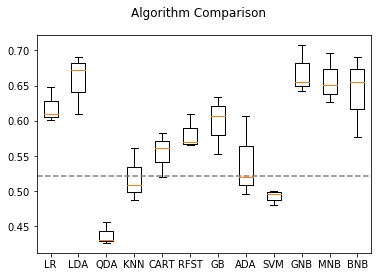

In [1297]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFST', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVM', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

print "\n{}:   {:0.3} ".format('Baseline', baseline, cv_results.std())
print "\n{:5.5}:  {:10.8}  {:20.18}  {:20.17}  {:20.17}".format\
        ("Model", "Features", "Train Set Accuracy", "CrossVal Accuracy", "Test Set Accuracy")

for name, model in models:
    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        this_model = model
        this_model.fit(X_train,y_train)
        print "{:5.5}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                (name, X_train.shape[1], metrics.accuracy_score(y_train, this_model.predict(X_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(y_test, this_model.predict(X_test)))
    except:
        print "    {:5.5}:   {} ".format(name, 'failed on this input dataset')

        
                
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline, color='grey', linestyle='--')
plt.show()

In [1218]:
# Which words are most common in the winner summaries ?
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# We can use the TfidfVectorizer to find ngrams for us
vect = TfidfVectorizer(ngram_range=(2,4), stop_words='english')

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(df_shows[df_shows['winner'] == 1]['summary'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'new york', 11),
 (u'drama series', 8),
 (u'york city', 6),
 (u'high school', 6),
 (u'men women', 5),
 (u'tv series', 5),
 (u'series based', 5),
 (u'video game', 5),
 (u'bugs bunny', 5),
 (u'new york city', 5),
 (u'tells story', 4),
 (u'young boy', 4),
 (u'comedy series', 4),
 (u'main character', 4),
 (u'united states', 4),
 (u'life new', 4),
 (u'series follows', 4),
 (u'anthology series', 3),
 (u'mr bean', 3),
 (u'prisoner cell', 3)]

In [1298]:
# Which words are most common in the loser summaries ?
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# We can use the TfidfVectorizer to find ngrams for us
vect = TfidfVectorizer(ngram_range=(2,4), stop_words='english')

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(df_shows[df_shows['winner'] == 0]['summary'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'real housewives', 12),
 (u'television series', 12),
 (u'los angeles', 11),
 (u'pop culture', 10),
 (u'series follows', 9),
 (u'new york', 9),
 (u'animated series', 7),
 (u'cartoon network', 7),
 (u'big brother', 6),
 (u'dance moms', 6),
 (u'reality series', 6),
 (u'best friend', 6),
 (u'high school', 5),
 (u'late night', 5),
 (u'best friends', 5),
 (u'nick jr', 5),
 (u'reality television series', 5),
 (u'plastic surgery', 5),
 (u'access hollywood', 5),
 (u'comedy series', 5)]

In [1299]:
# Sum matrix columns to see what has the most overall importance ?

print "Highest cumulative tfidf score for n_grams in winner shows"

tfidf_results = pd.DataFrame(X_train, columns= tfidf.get_feature_names())
tfidf_results['winners'] = y_train

winner_results = pd.DataFrame(tfidf_results[tfidf_results['winners'] ==1].sum(), columns=['tfidf_sum'])


high = winner_results.drop(['winners']).sort_values('tfidf_sum', axis=0, ascending=False).head(20).index
print  [str(r) for r in high]

winner_results.drop(['winners']).sort_values('tfidf_sum', axis=0, ascending=False).head(20)


Highest cumulative tfidf score for n_grams in winner shows
['new york', 'men women', 'documentary series', 'york city', 'new york city', 'high school', 'drama series', 'tells story', 'years ago', 'david attenborough', 'series created', 'years later', 'young man', 'comedy series', 'main character', '21st century', 'tv series', 'andrew davies', 'cable news', 'series based']


,tfidf_sum
new york,2.835972
men women,2.484786
documentary series,2.171334
york city,1.897754
new york city,1.897754
high school,1.743989
drama series,1.716267
tells story,1.685216
years ago,1.634339
david attenborough,1.522240


In [1300]:
# Sum matrix columns to see what has the most overall importance ?

print "Highest cumulative tfidf score for n_grams in loser shows"

tfidf_results = pd.DataFrame(X_train, columns= tfidf.get_feature_names())
tfidf_results['winners'] = y_train

winner_results = pd.DataFrame(tfidf_results[tfidf_results['winners'] == 0].sum(), columns=['tfidf_sum'])

low = winner_results.drop(['winners']).sort_values('tfidf_sum', axis=0, ascending=False).head(20).index

print  [str(r) for r in low]
winner_results.drop(['winners']).sort_values('tfidf_sum', axis=0, ascending=False).head(20)

Highest cumulative tfidf score for n_grams in loser shows
['reality series', 'television series', 'los angeles', 'real housewives', 'things just', 'best friend', 'group teenagers', 'series follows', 'restaurant industry', 'new york', 'high school', 'children ages', 'big brother', 'recent divorce', 'series features', 'cartoon network', 'football team', 'plastic surgery', 'bizarre adventures', 'nick jr']


,tfidf_sum
reality series,3.535573
television series,2.715189
los angeles,2.582930
real housewives,2.160853
things just,2.000000
best friend,1.958176
group teenagers,1.791283
series follows,1.772954
restaurant industry,1.707107
new york,1.662150


## Model using data other than the TV show summary text 

In [1301]:
# Get list of columns for the useful non-summary data.  Dropping the "unknown" columns will solve
# the colinearity issue with dummied columns, as these will be the dropped dummies.  
# Dropping premiered as it is a datatime and standardize can't handle it.  Also dropping
# weight as it is not understood, and rating and winner as they are the targets

cols = [x for x in df_shows.columns if x not in ['rating', 'weight', 'updated', 'premiered', 'summary', 'id', \
                                                 'gn_unknown', 'sched_unknown', 'sched_time_unknown', \
                                                 'country_name', 'country_tz', 'network_name', 'name', 'winner']]
cols

[u'status',
 u'language',
 u'runtime',
 u'type',
 u'network',
 u'gn_action',
 u'gn_adult',
 u'gn_adventure',
 u'gn_anime',
 u'gn_children',
 u'gn_comedy',
 u'gn_crime',
 u'gn_drama',
 u'gn_espionage',
 u'gn_family',
 u'gn_fantasy',
 u'gn_food',
 u'gn_history',
 u'gn_horror',
 u'gn_legal',
 u'gn_medical',
 u'gn_music',
 u'gn_mystery',
 u'gn_nature',
 u'gn_romance',
 u'gn_science-fiction',
 u'gn_sports',
 u'gn_supernatural',
 u'gn_thriller',
 u'gn_travel',
 u'gn_war',
 u'gn_western',
 u'sched_friday',
 u'sched_monday',
 u'sched_saturday',
 u'sched_sunday',
 u'sched_thursday',
 u'sched_tuesday',
 u'sched_wednesday',
 u'sched_time_00:00',
 u'sched_time_00:30',
 u'sched_time_00:50',
 u'sched_time_00:55',
 u'sched_time_01:00',
 u'sched_time_01:05',
 u'sched_time_01:30',
 u'sched_time_01:35',
 u'sched_time_02:00',
 u'sched_time_02:05',
 u'sched_time_08:00',
 u'sched_time_10:00',
 u'sched_time_11:00',
 u'sched_time_12:00',
 u'sched_time_13:00',
 u'sched_time_13:30',
 u'sched_time_14:00',
 u'sc

In [1302]:
# Dummy country code, network id, status, language, and type
df_showsd = pd.get_dummies(df_shows, columns=['network_id'], prefix='NW', prefix_sep='_')

df_showsd = df_showsd.drop('NW_', 1)
df_showsd = df_showsd.drop('network', 1)


In [1303]:
df_showsd = pd.get_dummies(df_showsd, columns=['country_code'], prefix='C', prefix_sep='_', drop_first=True)
df_showsd = pd.get_dummies(df_showsd, columns=['status'], prefix='ST', prefix_sep='_', drop_first=True)
df_showsd = pd.get_dummies(df_showsd, columns=['language'], prefix='L', prefix_sep='_', drop_first=True)
df_showsd = pd.get_dummies(df_showsd, columns=['type'], prefix='T', prefix_sep='_', drop_first=True)


In [1304]:
# Handle any NaN values that remain
shows_clean = df_showsd.dropna()

In [1305]:
# We have 326 total samples left, about 1/3 loser and 2/3 winner
# Seems reasonable to proceed with a classification model

print "Number winner samples:", shows_clean['winner'].sum()
print "Number loser samples:", len(shows_clean[shows_clean['winner'] == 0])

Number winner samples: 230
Number loser samples: 121


In [1306]:
cols = [x for x in shows_clean.columns if x not in ['rating', 'weight', 'updated', 'premiered', 'summary', 'id', \
                                                 'gn_unknown', 'sched_unknown', 'sched_time_unknown', \
                                                 'country_name', 'country_tz', 'network_name', 'name', 'winner']]
cols

[u'runtime',
 u'gn_action',
 u'gn_adult',
 u'gn_adventure',
 u'gn_anime',
 u'gn_children',
 u'gn_comedy',
 u'gn_crime',
 u'gn_drama',
 u'gn_espionage',
 u'gn_family',
 u'gn_fantasy',
 u'gn_food',
 u'gn_history',
 u'gn_horror',
 u'gn_legal',
 u'gn_medical',
 u'gn_music',
 u'gn_mystery',
 u'gn_nature',
 u'gn_romance',
 u'gn_science-fiction',
 u'gn_sports',
 u'gn_supernatural',
 u'gn_thriller',
 u'gn_travel',
 u'gn_war',
 u'gn_western',
 u'sched_friday',
 u'sched_monday',
 u'sched_saturday',
 u'sched_sunday',
 u'sched_thursday',
 u'sched_tuesday',
 u'sched_wednesday',
 u'sched_time_00:00',
 u'sched_time_00:30',
 u'sched_time_00:50',
 u'sched_time_00:55',
 u'sched_time_01:00',
 u'sched_time_01:05',
 u'sched_time_01:30',
 u'sched_time_01:35',
 u'sched_time_02:00',
 u'sched_time_02:05',
 u'sched_time_08:00',
 u'sched_time_10:00',
 u'sched_time_11:00',
 u'sched_time_12:00',
 u'sched_time_13:00',
 u'sched_time_13:30',
 u'sched_time_14:00',
 u'sched_time_14:30',
 u'sched_time_15:00',
 u'sched_t

In [1335]:
# Generate X matrix and y target

X = shows_clean[cols]
y = shows_clean['winner'].values

In [1336]:
# Baseline 
winner_avg = y.mean()
baseline = max(winner_avg, 1-winner_avg)
print baseline


0.655270655271


In [1337]:
# Test Train Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [1338]:
print X_train.shape,  len(y_train)
print X_test.shape,  len(y_test)

(263, 240) 263
(88, 240) 88


In [1339]:
#  Standardize - 

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)# Test Train Split



In [1340]:
# Gridsearch for best C and penalty
gs_params = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,5,100)
}
from sklearn.model_selection import GridSearchCV
lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=3, verbose=1, n_jobs=-1)


In [1341]:
lr_gridsearch.fit(Xs_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.26186e-05, ...,   7.92483e+04,   1.00000e+05]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [1342]:
# best score on the training data:
lr_gridsearch.best_score_

0.9125475285171103

In [1343]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.068926121043496949, 'penalty': 'l2', 'solver': 'liblinear'}

In [1344]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [1345]:
# Score it on the testing data:
best_lr.score(Xs_test, y_test)

0.88636363636363635

In [1346]:
# Much better than baseline, and we can find the most important factors and run all the classifiers using
# those factors.

In [1347]:
coef_df = pd.DataFrame({
        'features': X.columns,
        'log odds': best_lr.coef_[0],
        'percentage change in odds': np.round(np.exp(best_lr.coef_[0])*100-100,2)
    })

In [1348]:
coef_df.sort_values(by='percentage change in odds', ascending=0)

,features,log odds,percentage change in odds
6,gn_comedy,0.500129,64.89
237,T_Scripted,0.477513,61.21
232,T_Documentary,0.268693,30.83
8,gn_drama,0.254062,28.93
3,gn_adventure,0.246904,28.01
90,NW_8,0.242839,27.49
94,NW_12,0.207017,23.00
114,NW_37,0.201048,22.27
7,gn_crime,0.192888,21.27
83,sched_time_23:30,0.178175,19.50


In [1349]:
# Create a subset of "coef_df" DataFrame with most important coefficients
imp_coefs = pd.concat([coef_df.sort_values(by='percentage change in odds', ascending=0).head(10),
                     coef_df.sort_values(by='percentage change in odds', ascending=0).tail(10)])

In [1350]:
imp_coefs.set_index('features', inplace=True)

In [1351]:
imp_coefs

,log odds,percentage change in odds
features,,
gn_comedy,0.500129,64.89
T_Scripted,0.477513,61.21
T_Documentary,0.268693,30.83
gn_drama,0.254062,28.93
gn_adventure,0.246904,28.01
NW_8,0.242839,27.49
NW_12,0.207017,23.00
NW_37,0.201048,22.27
gn_crime,0.192888,21.27


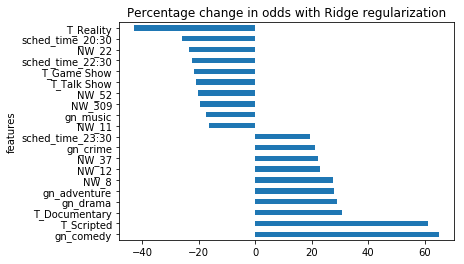

In [1352]:
# Plot important coefficients
imp_coefs['percentage change in odds'].plot(kind = "barh")
plt.title("Percentage change in odds with Ridge regularization")
plt.show()

In [1353]:
df_shows[df_shows['network_id'] == 309]

,status,rating,weight,updated,name,language,premiered,summary,runtime,type,...,sched_time_23:00,sched_time_23:02,sched_time_23:15,sched_time_23:30,sched_time_unknown,country_code,country_name,country_tz,network_id,network_name
279,Running,8.7,40,2017-08-22 19:26:37,I Live with Models,English,2015-02-23 00:00:00,tommy heads to new york city with scarlet as t...,30,Scripted,...,0.0,0.0,0.0,0.0,0.0,GB,United Kingdom,Europe/London,309,Comedy Central
535,To Be Determined,6.5,0,2016-01-13 15:12:17,Brotherhood,English,2015-06-02 00:00:00,twentysomethings dan and toby are in over thei...,30,Scripted,...,NaN,NaN,NaN,NaN,NaN,GB,United Kingdom,Europe/London,309,Comedy Central


In [1354]:
# Get list of features and re-run model with just the 20 most important features
imp_features = imp_coefs.index

In [1355]:
# Set up X and y
X = shows_clean[imp_features]
y = shows_clean['winner'].values

In [1356]:
# Baseline
winner_avg = y.mean()
baseline = max(winner_avg, 1-winner_avg)
print baseline

0.655270655271


In [1357]:
# Test Train Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [1358]:
print X_train.shape,  len(y_train)
print X_test.shape,  len(y_test)

(263, 20) 263
(88, 20) 88


In [1359]:
#  Standardize - 

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)# Test Train Split



Baseline:   0.655 

Model:  Features    Train Set Accuracy    CrossVal Accuracy     Test Set Accuracy   
LR        20         0.905               0.874 +/- 0.010         0.909 
LDA       20         0.901               0.890 +/- 0.020         0.875 
QDA       20         0.669               0.448 +/- 0.082         0.682 
KNN       20         0.909               0.905 +/- 0.005         0.886 
CART      20         0.943               0.894 +/- 0.019         0.898 
RFST      20         0.939               0.909 +/- 0.000         0.886 
GB        20         0.943               0.905 +/- 0.020         0.898 
ADA       20         0.916               0.897 +/- 0.032         0.920 
SVM       20         0.863               0.848 +/- 0.014         0.818 
GNB       20         0.616               0.673 +/- 0.057         0.614 
MNB       20         0.886               0.886 +/- 0.010         0.898 
BNB       20         0.905               0.901 +/- 0.010         0.920 


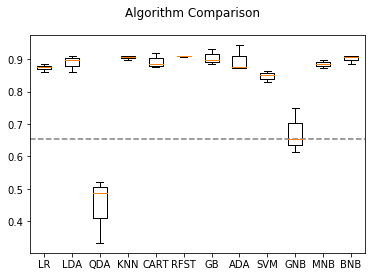

In [1360]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFST', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVM', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

print "\n{}:   {:0.3} ".format('Baseline', baseline, cv_results.std())
print "\n{:5.5}:  {:10.8}  {:20.18}  {:20.17}  {:20.17}".format\
        ("Model", "Features", "Train Set Accuracy", "CrossVal Accuracy", "Test Set Accuracy")

for name, model in models:
    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        this_model = model
        this_model.fit(X_train,y_train)
        print "{:5.5}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                (name, X_train.shape[1], metrics.accuracy_score(y_train, this_model.predict(X_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(y_test, this_model.predict(X_test)))
    except:
        print "    {:5.5}:   {} ".format(name, 'failed on this input dataset')

        
                
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline, color='grey', linestyle='--')
plt.show()